# Kopp et al 2021 Plotting 
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to perform a brief evaluation of trained models on the Kopp21 et al dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [4]:
# Configure EUGENe 
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/kopp21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/kopp21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/kopp21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/kopp21"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/kopp21"
eu.settings.verbosity = logging.ERROR

# Load in the test `SeqData`(s)

In [5]:
# Load in the training data that's been predicted on
sdata_test = eu.dl.read_h5sd(
    filename=os.path.join(eu.settings.output_dir, "jund_test_predictions_all.h5sd")
)
sdata_test

SeqData object with = 64309 seqs
seqs = (64309,)
names = (64309,)
rev_seqs = None
ohe_seqs = (64309, 4, 500)
ohe_rev_seqs = (64309, 4, 500)
seqs_annot: 'Kopp21CNN_trial_1_target_predictions', 'Kopp21CNN_trial_2_target_predictions', 'Kopp21CNN_trial_3_target_predictions', 'Kopp21CNN_trial_4_target_predictions', 'Kopp21CNN_trial_5_target_predictions', 'chr', 'dsCNN_trial_1_target_predictions', 'dsCNN_trial_2_target_predictions', 'dsCNN_trial_3_target_predictions', 'dsCNN_trial_4_target_predictions', 'dsCNN_trial_5_target_predictions', 'dsFCN_trial_1_target_predictions', 'dsFCN_trial_2_target_predictions', 'dsFCN_trial_3_target_predictions', 'dsFCN_trial_4_target_predictions', 'dsFCN_trial_5_target_predictions', 'dsHybrid_trial_1_target_predictions', 'dsHybrid_trial_2_target_predictions', 'dsHybrid_trial_3_target_predictions', 'dsHybrid_trial_4_target_predictions', 'dsHybrid_trial_5_target_predictions', 'end', 'start', 'target', 'train_test'
pos_annot: None
seqsm: None
uns: None

# Generate performance figures

,average_precision,prediction_groups
Kopp21CNN_trial_1_target_predictions,0.341872,Kopp21CNN
Kopp21CNN_trial_2_target_predictions,0.353977,Kopp21CNN
Kopp21CNN_trial_3_target_predictions,0.361672,Kopp21CNN
Kopp21CNN_trial_4_target_predictions,0.387772,Kopp21CNN
Kopp21CNN_trial_5_target_predictions,0.376893,Kopp21CNN
dsCNN_trial_1_target_predictions,0.395169,dsCNN
dsCNN_trial_2_target_predictions,0.434837,dsCNN
dsCNN_trial_3_target_predictions,0.416790,dsCNN
dsCNN_trial_4_target_predictions,0.426044,dsCNN
dsCNN_trial_5_target_predictions,0.451920,dsCNN


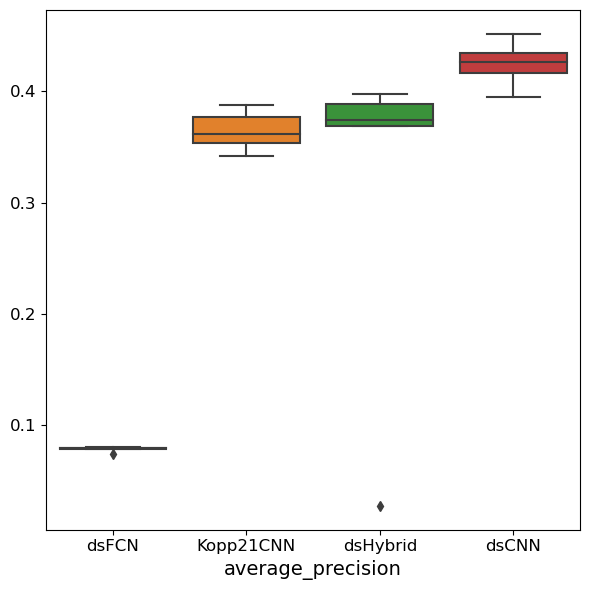

In [12]:
eu.pl.performance_summary(
    sdata_test,
    target="target",
    prediction_groups=["Kopp21CNN"]*5 + ["dsCNN"]*5 + ["dsFCN"]*5 + ["dsHybrid"]*5,
    order=["dsFCN", "Kopp21CNN", "dsHybrid", "dsCNN"],
    metrics=["average_precision"],
    figsize=(6, 6),
    save=os.path.join(eu.settings.figure_dir, "jund_auprc_boxplot.pdf")
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cellar/us

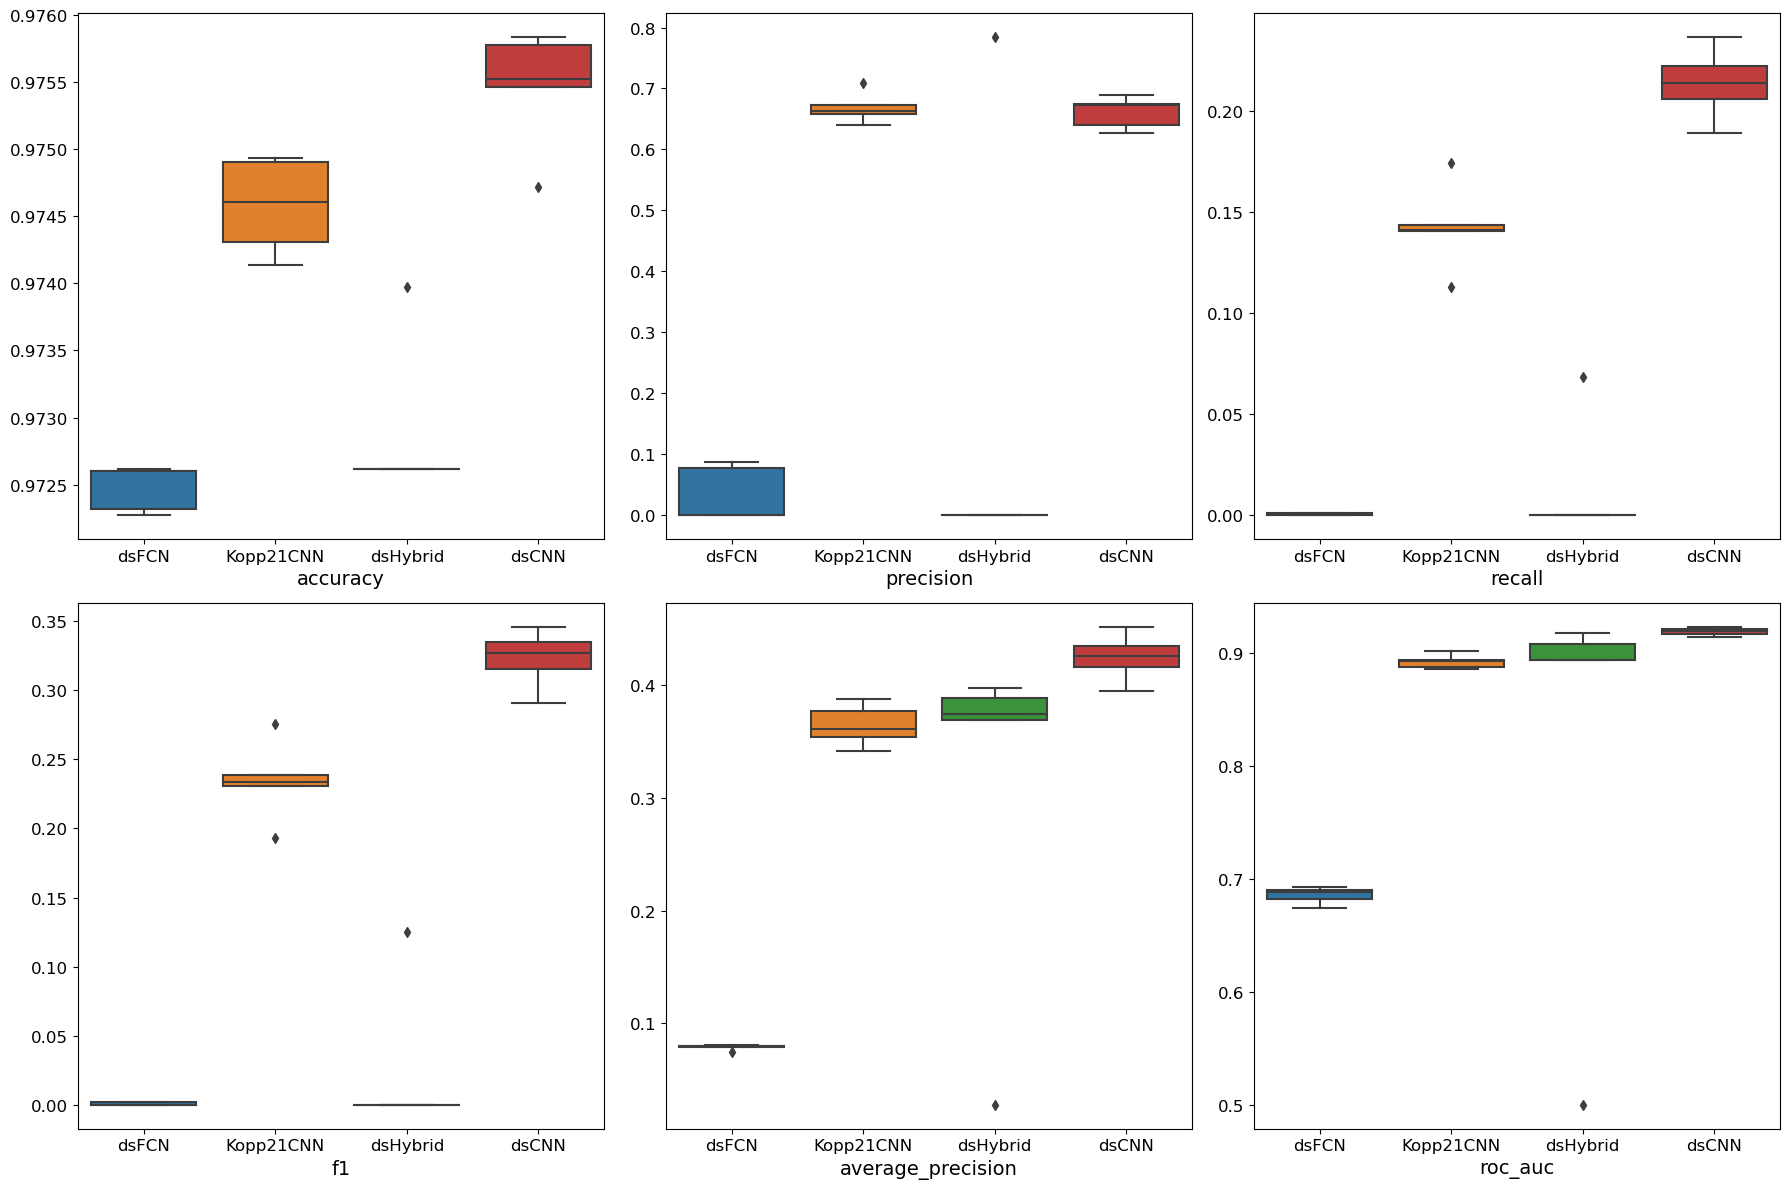

In [13]:
# Summarize performance across models for a metric
model_scores = eu.pl.performance_summary(
    sdata_test,
    target="target",
    prediction_groups=["Kopp21CNN"]*5 + ["dsCNN"]*5 + ["dsFCN"]*5 + ["dsHybrid"]*5, 
    order=["dsFCN", "Kopp21CNN", "dsHybrid", "dsCNN"],
    metrics=["accuracy", "precision", "recall", "f1", "average_precision", "roc_auc"],
    figsize=(6, 6),
    save=os.path.join(eu.settings.figure_dir, "jund_performance_summary.pdf")
)

In [14]:
# Save model performance as table
model_scores.to_csv(os.path.join(eu.settings.output_dir, "jund_performance_summary.tsv"), sep="\t")

<AxesSubplot:ylabel='auPRC'>

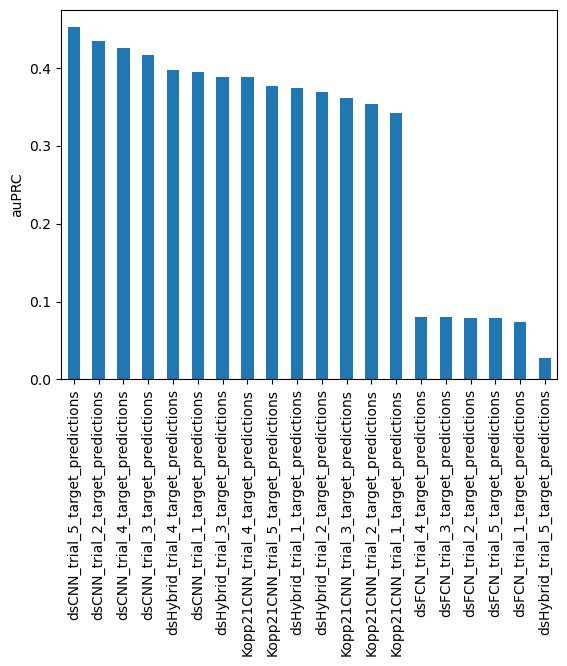

In [15]:
# Identify the best model from returned model scores
auprc_sorted = model_scores["average_precision"].sort_values(ascending=False)
auprc_sorted.plot(kind="bar", ylabel="auPRC")

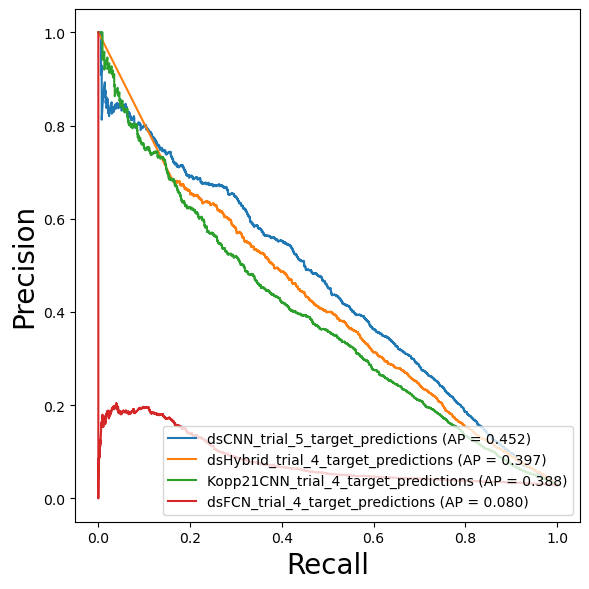

In [16]:
# Plot the performances across species for the best model
model_scores["model_type"] = [model.split("_")[0] for model in model_scores.index]
best_preds = model_scores.sort_values(by="average_precision", ascending=False).groupby("model_type").head(1).index
eu.pl.auprc(
    sdata_test,
    targets=["target"]*4, 
    predictions=best_preds,
    labels=best_preds,
    save=os.path.join(eu.settings.figure_dir, "jund_best_model_auprc.pdf")
)
plt.show()

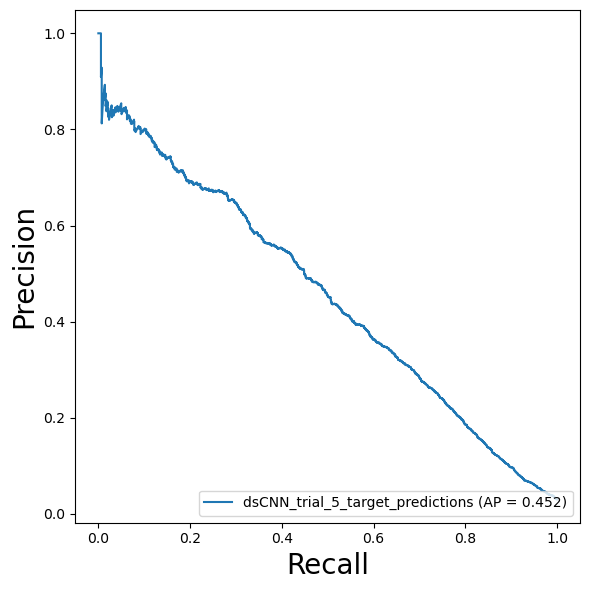

In [17]:
# Plot the performances across species for the best model
eu.pl.auprc(
    sdata_test,
    targets="target",
    predictions=best_preds[0],
    labels=best_preds[0],
    save=os.path.join(eu.settings.figure_dir, "jund_best_single_model_auprc.pdf")
)
plt.show()

# Seq track visualizations

In [46]:
model_type = "Kopp21CNN"
trial = 4

In [47]:
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, f"jund_test_predictions_and_interpretations_{model_type}.h5sd"))

In [48]:
top10 = sdata_test[f"{model_type}_trial_{trial}_target_predictions"].sort_values(ascending=False).iloc[:10].index

In [50]:
top10_idx = np.argsort(sdata_test[f"{model_type}_trial_{trial}_target_predictions"].values)[::-1][:10]

In [26]:
np.where(np.sum(sdata_test.uns["GradientSHAP_forward_imps"][top10_idx], axis=1) > 0.1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9,
        9, 9, 9, 9, 9, 9]),
 array([387, 389, 390, 391, 392, 393, 394, 395, 397, 399, 400,  17,  97,
         98,  99, 100, 103, 104, 114, 120, 153, 155, 156, 157, 158, 159,
        161, 162, 165, 166, 167, 187, 189, 190, 191, 192, 193, 194, 199,
        200,  75,  76,  77,  93, 104, 135,  72,  74,  75,  76,  77,  78,
         79,  90,  91,  93,  95,  97,  98, 271, 300, 302, 308, 315, 316,
        317, 318, 319, 320, 321, 322, 323, 324, 326, 327, 328, 329, 330,
        331, 332, 335, 340, 375, 378, 380,  23,  49,  51, 272, 274, 275,
        276, 277, 278, 279, 281, 288, 289, 290, 291, 293, 294, 295, 296,
        297, 298, 

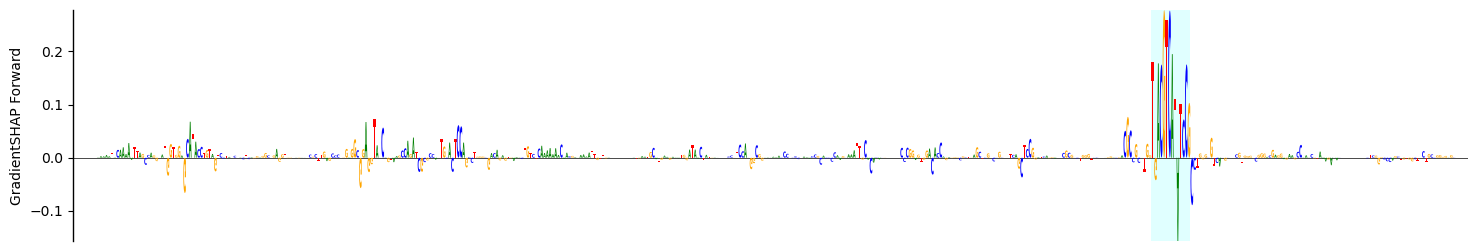

In [37]:
eu.pl.lm_seq_track(
    sdata_test,
    seq_id=top10[0],
    uns_key="GradientSHAP_forward_imps",
    ylabel="GradientSHAP Forward",
    figsize=(18, 3),
    highlights=[(387, 400)],
    highlight_colors = ["lightcyan"],
    save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_forward_imps_top1_with_color.pdf")
)

In [29]:
np.where(np.sum(sdata_test.uns["GradientSHAP_reverse_imps"][top10_idx], axis=1) > 0.1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([105, 107, 108, 109, 110, 111, 112, 114, 183, 186, 187, 391,  38,
        305, 308, 309, 310, 311, 378, 380, 381, 382, 383, 386, 387, 389,
        419, 434, 435, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
        447, 448, 449, 451, 452, 454, 459, 253, 269, 276, 394, 408, 409,
        410, 411, 412, 413, 414, 415, 416, 417, 419, 420, 421, 422, 423,
        426, 433, 435, 436, 445,  45, 398, 402, 404, 405, 406, 420, 422,
        423, 424, 425, 426, 427, 429, 161, 164, 218, 233, 235, 238, 240,
        

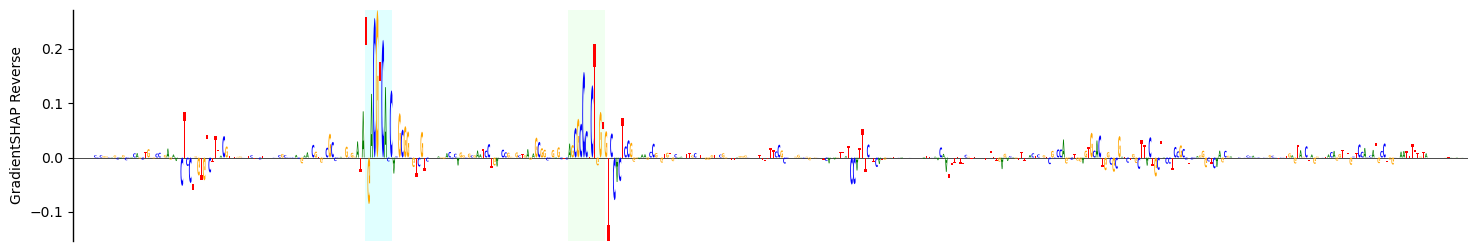

In [38]:
eu.pl.lm_seq_track(
    sdata_test,
    seq_id=top2[0],
    uns_key="GradientSHAP_reverse_imps",
    ylabel="GradientSHAP Reverse",
    figsize=(18, 3),
    highlights=[(105,114), (178, 190)],
    highlight_colors = ["lightcyan", "honeydew"],
    save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_reverse_imps_top1_with_color.pdf")
)

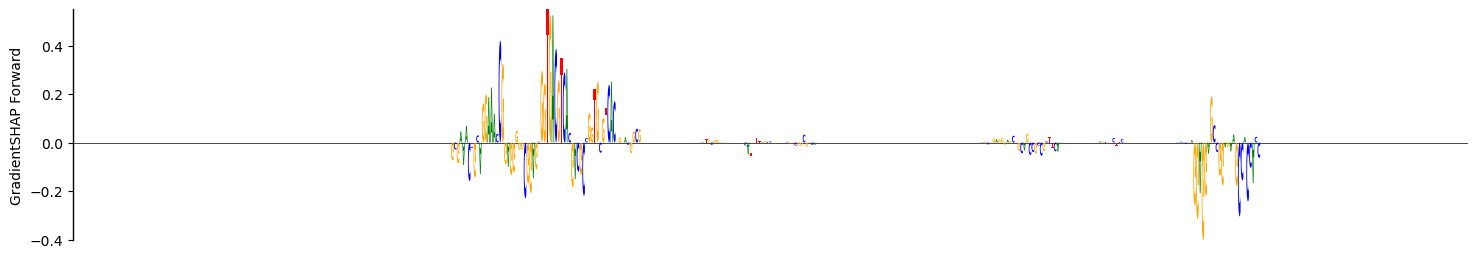

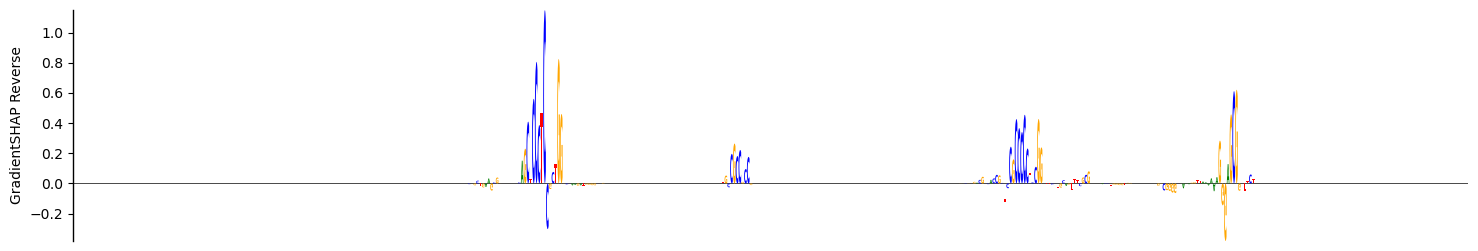

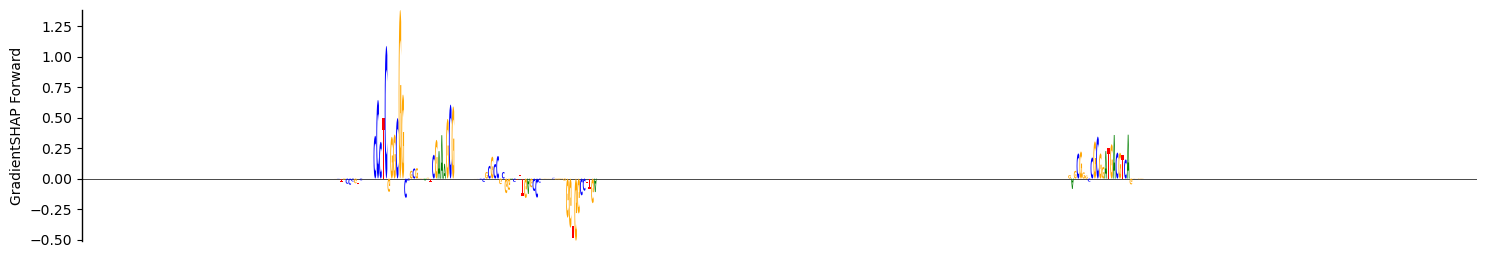

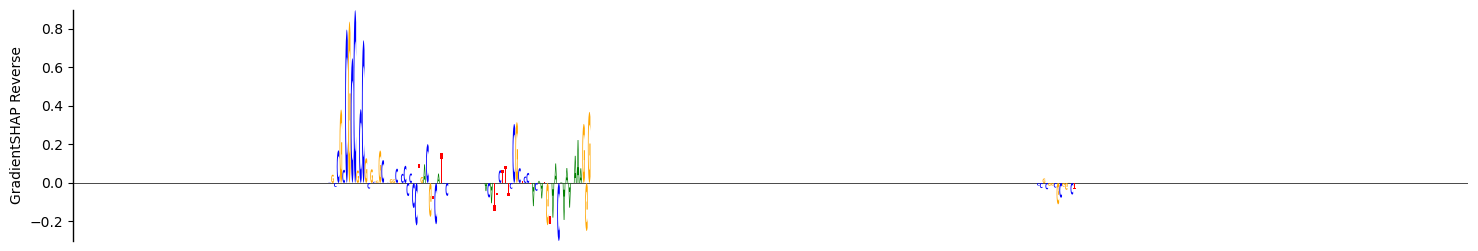

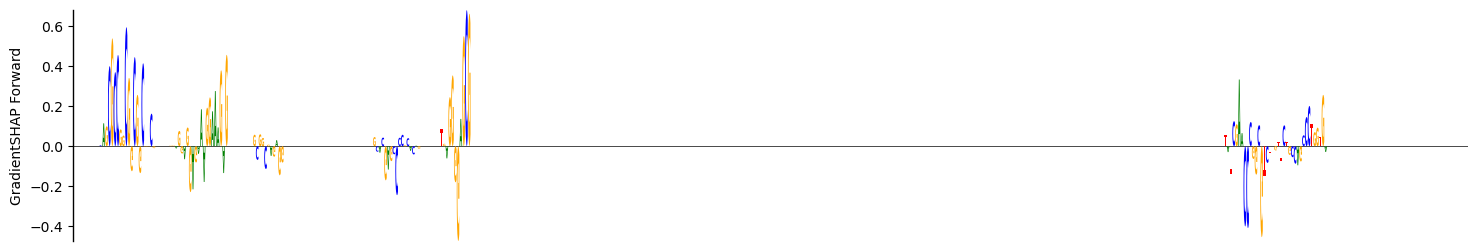

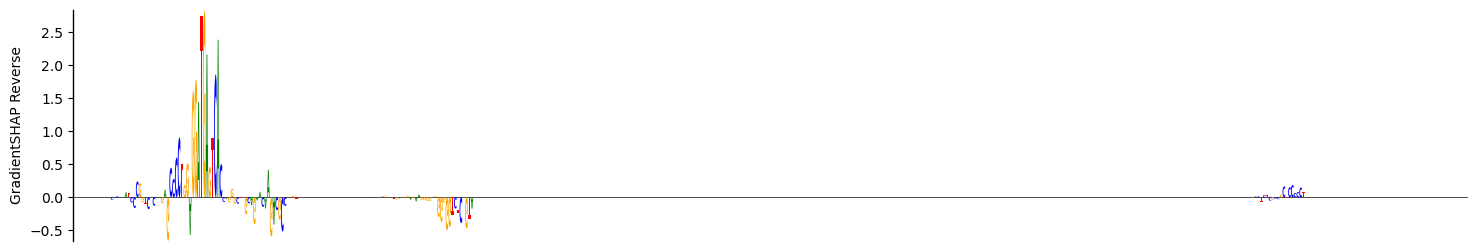

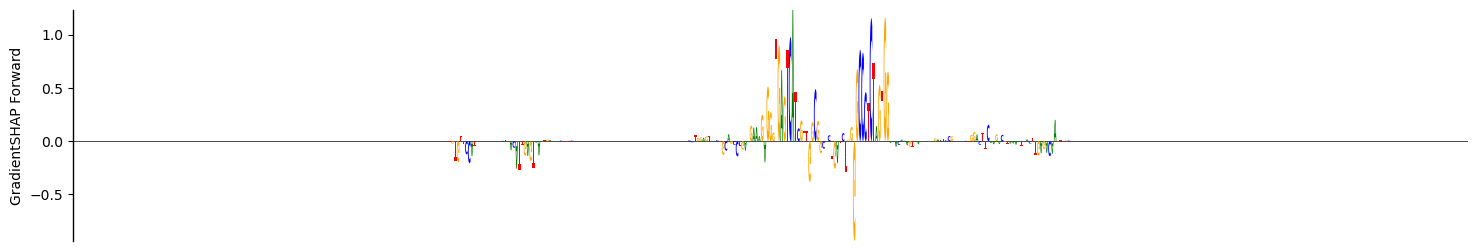

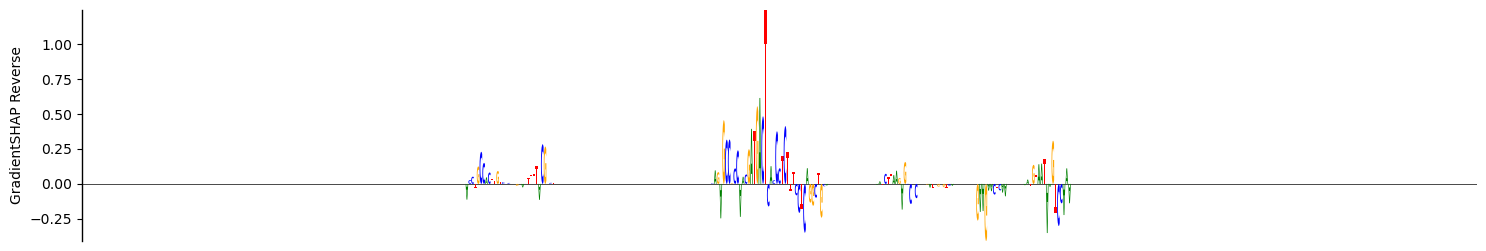

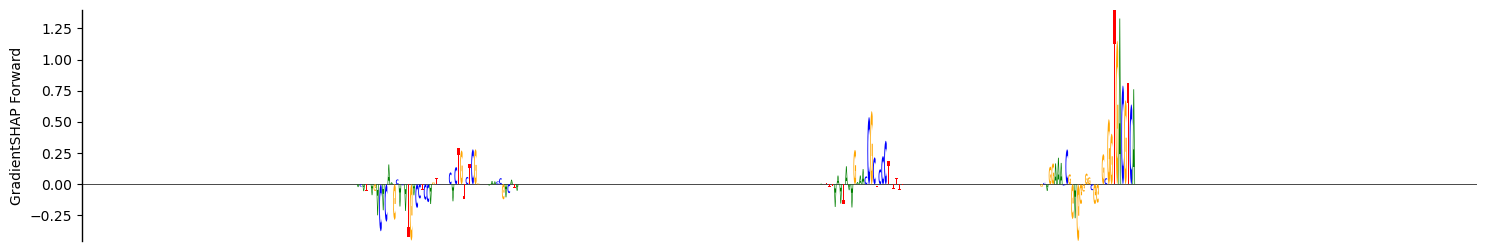

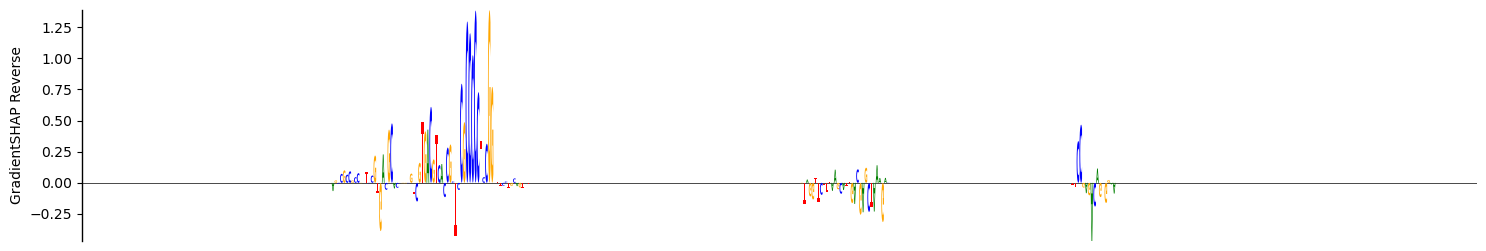

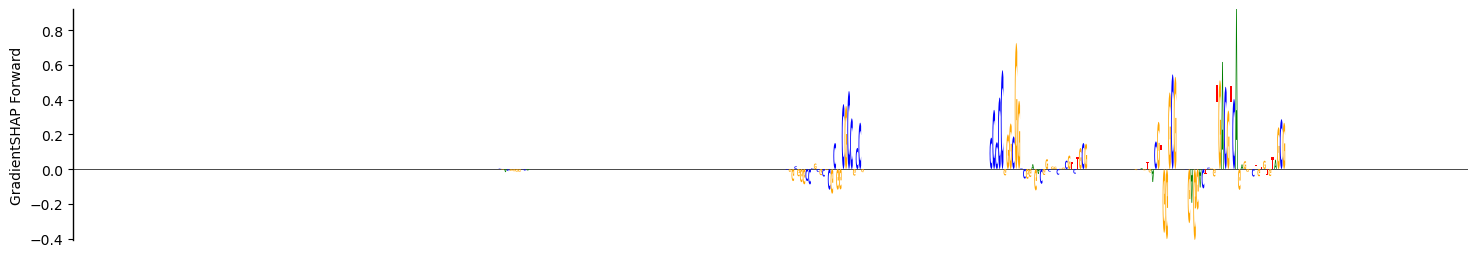

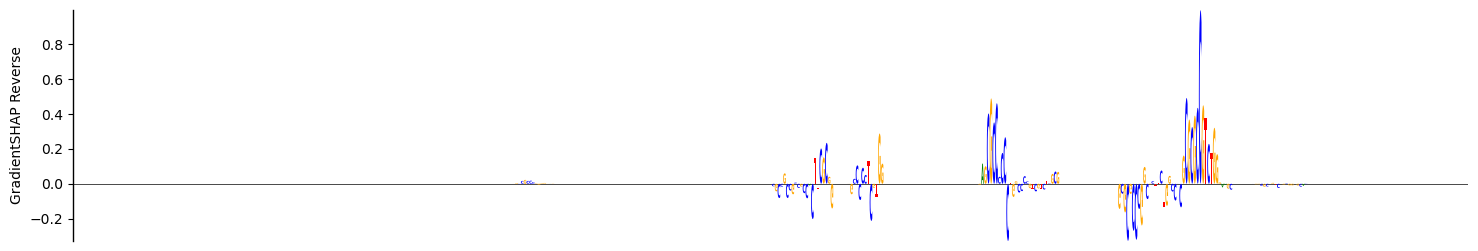

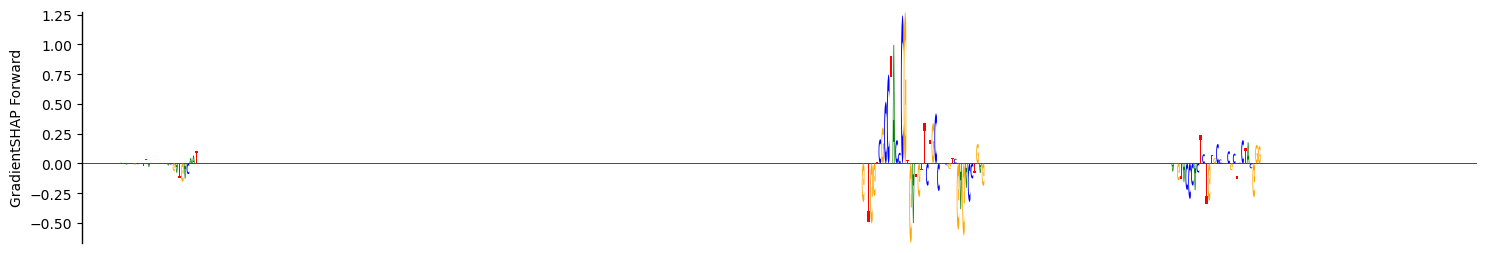

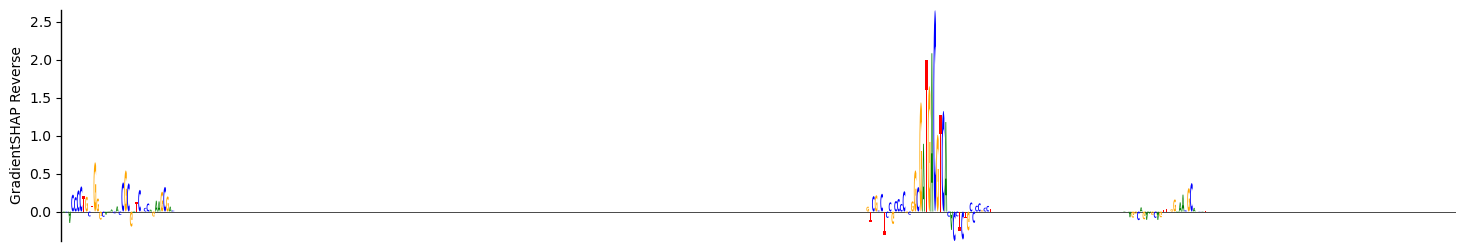

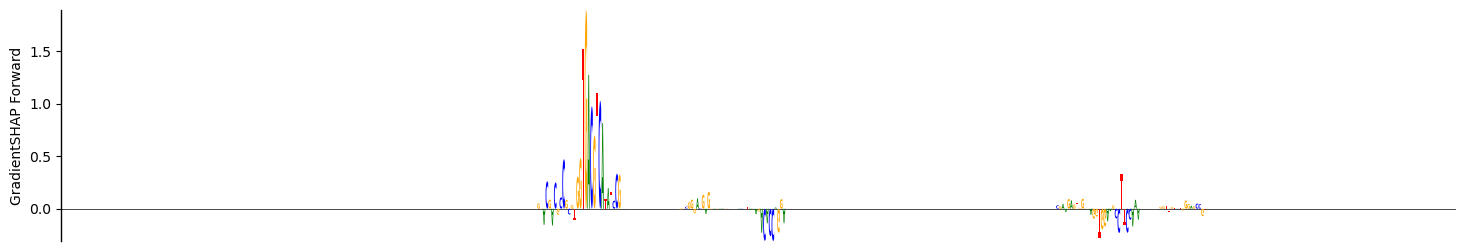

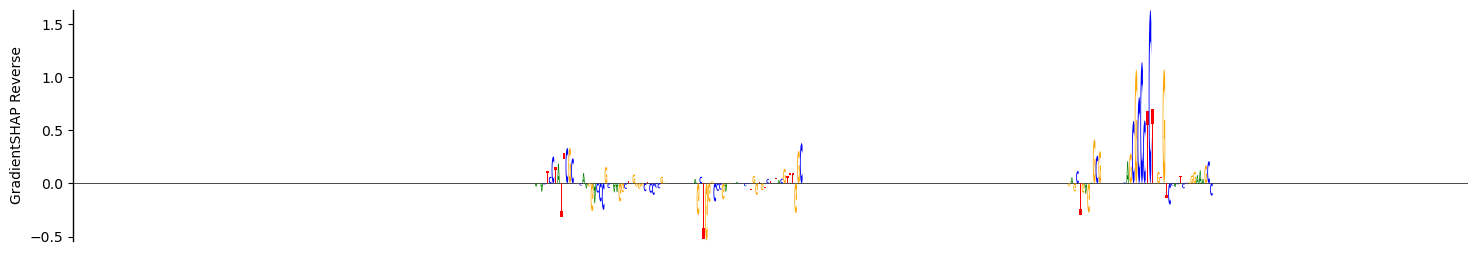

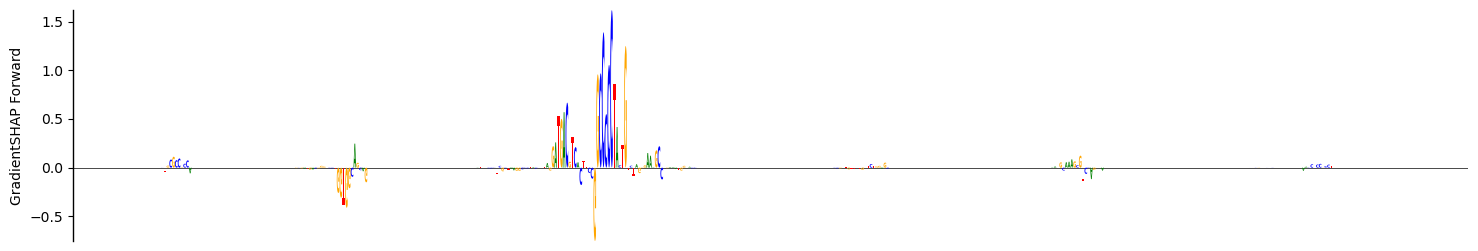

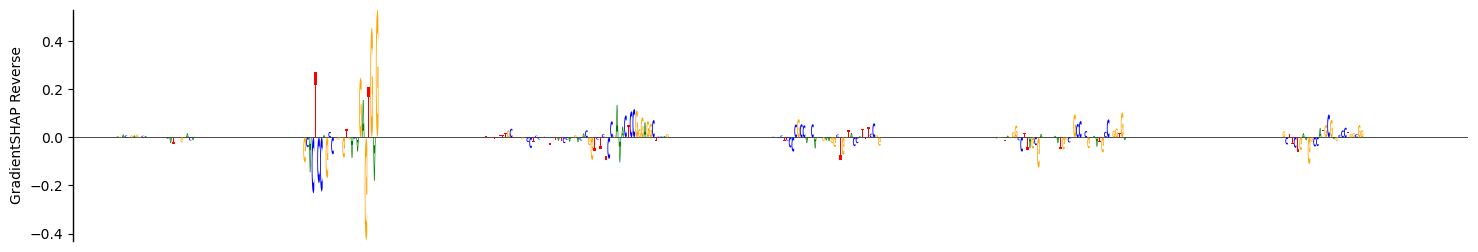

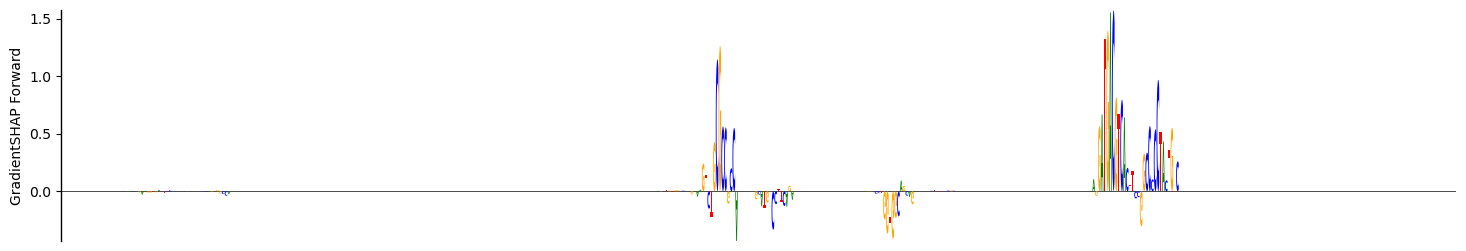

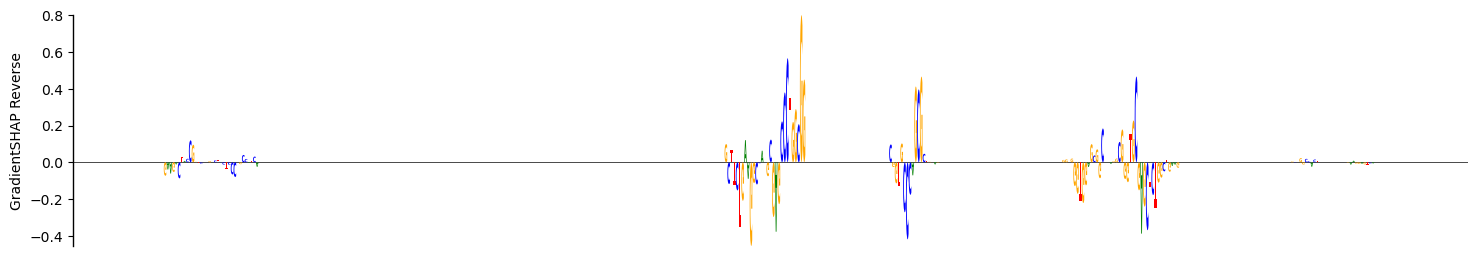

In [51]:
for i, seq in enumerate(top10):
    eu.pl.lm_seq_track(
        sdata_test,
        seq_id=top10[i],
        uns_key="GradientSHAP_forward_imps",
        ylabel="GradientSHAP Forward",
        figsize=(18, 3),
        save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_forward_imps_top{i+1}.pdf")
    )
    eu.pl.lm_seq_track(
        sdata_test,
        seq_id=top10[i],
        uns_key="GradientSHAP_reverse_imps",
        ylabel="GradientSHAP Reverse",
        figsize=(18, 3),
        save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_reverse_imps_top{i+1}.pdf")
    )

# Filter viz

Plotting and saving filters 1-10


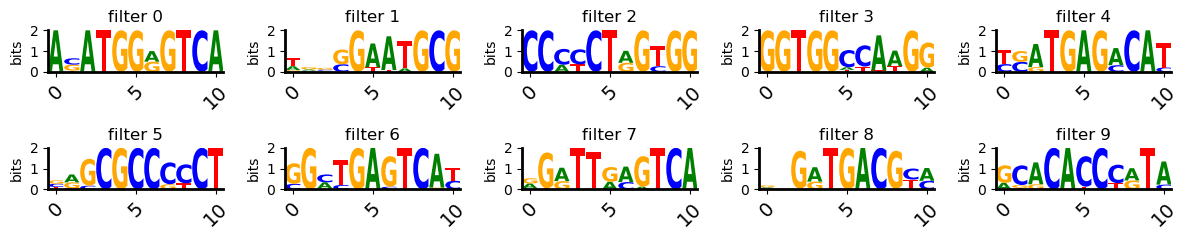

In [52]:
for i in range(1):
    start_filter = i*10
    end_filter = (i*10) + 10
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    eu.pl.lm_multifilter_viz(
        sdata_test,
        filter_ids=list(sdata_test.uns["pfms"].keys())[start_filter:end_filter],
        num_rows=2,
        num_cols=5,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

# TomTom results

In [64]:
model_type = "CNN"

In [65]:
res = pd.read_csv(os.path.join(eu.settings.output_dir, f"jund_best_{model_type}_model_filters_tomtom.tsv"), sep="\t", comment="#")

In [66]:
res_sig = res[res["q-value"] < 0.05].sort_values(by="q-value")

In [67]:
res_sig

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
4,filter1,CTCF_HUMAN.H11MO.0.A,6,6.229530e-08,0.000025,0.000050,11,CCCCTAGTGGC,TGGCGCCCCCTGGTGGCCA,-
11,filter2,ATF2_HUMAN.H11MO.0.B,0,2.762690e-07,0.000111,0.000218,11,ATGACGTCATC,ATGACGTCATC,-
12,filter2,CREB1_HUMAN.H11MO.0.A,-1,2.024800e-06,0.000812,0.000799,10,ATGACGTCATC,TGACGTCATCG,-
148,filter9,FOSL2_HUMAN.H11MO.0.A,0,3.714510e-06,0.001490,0.000958,11,GGATGACTCAT,GGATGAGTCATC,+
147,filter9,JUN_HUMAN.H11MO.0.A,-1,2.444770e-06,0.000980,0.000958,10,GGATGACTCAT,GATGACTCATC,-
149,filter9,JUND_HUMAN.H11MO.0.A,-1,5.897810e-06,0.002365,0.001141,10,GGATGACTCAT,GATGACTCATC,-
150,filter9,FOSB_HUMAN.H11MO.0.A,-2,7.852310e-06,0.003149,0.001215,9,GGATGACTCAT,ATGACTCAT,-
151,filter9,FOSL1_HUMAN.H11MO.0.A,-1,9.608510e-06,0.003853,0.001239,10,GGATGACTCAT,GGTGACTCATCC,-
116,filter7,CTCFL_HUMAN.H11MO.0.A,1,5.875090e-06,0.002356,0.002356,11,AGCGCCCCCTA,CGGCGCCCCCTGGCGGC,-
115,filter7,CTCF_HUMAN.H11MO.0.A,1,3.465980e-06,0.001390,0.002356,11,AGCGCCCCCTA,TGGCGCCCCCTGGTGGCCA,-


In [91]:
res_sig[res_sig["Target_ID"] == "MA0535.1"]

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
247,filter8,MA0535.1,2,0.000036,0.069842,0.006408,13,CCCCCCCCCCCCCCA,CAGGCGCCGCCGCCG,+
877,filter31,MA0535.1,0,0.000726,1.419280,0.036082,15,CCGCCCCCGCGGCCC,CAGGCGCCGCCGCCG,+


In [61]:
res_sig.value_counts("Target_ID").iloc[:25]

Target_ID
CTCFL_HUMAN.H11MO.0.A    2
CTCF_HUMAN.H11MO.0.A     2
ATF1_HUMAN.H11MO.0.B     1
FOS_HUMAN.H11MO.0.A      1
NFE2_HUMAN.H11MO.0.A     1
NF2L2_HUMAN.H11MO.0.A    1
MEIS1_HUMAN.H11MO.0.A    1
MAFB_HUMAN.H11MO.0.B     1
JUN_HUMAN.H11MO.0.A      1
JUND_HUMAN.H11MO.0.A     1
JUNB_HUMAN.H11MO.0.A     1
HXA9_HUMAN.H11MO.0.B     1
HXA1_HUMAN.H11MO.0.C     1
HLF_HUMAN.H11MO.0.C      1
FOSL1_HUMAN.H11MO.0.A    1
FOSL2_HUMAN.H11MO.0.A    1
ATF2_HUMAN.H11MO.0.B     1
FOSB_HUMAN.H11MO.0.A     1
CREM_HUMAN.H11MO.0.C     1
CREB1_HUMAN.H11MO.0.A    1
CEBPG_HUMAN.H11MO.0.B    1
BATF_HUMAN.H11MO.0.A     1
BACH2_HUMAN.H11MO.0.A    1
BACH1_HUMAN.H11MO.0.A    1
ATF4_HUMAN.H11MO.0.A     1
dtype: int64

In [69]:
res_sig.groupby("Query_ID").head(1)

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
4,filter1,CTCF_HUMAN.H11MO.0.A,6,6.229530e-08,0.000025,0.000050,11,CCCCTAGTGGC,TGGCGCCCCCTGGTGGCCA,-
11,filter2,ATF2_HUMAN.H11MO.0.B,0,2.762690e-07,0.000111,0.000218,11,ATGACGTCATC,ATGACGTCATC,-
148,filter9,FOSL2_HUMAN.H11MO.0.A,0,3.714510e-06,0.001490,0.000958,11,GGATGACTCAT,GGATGAGTCATC,+
116,filter7,CTCFL_HUMAN.H11MO.0.A,1,5.875090e-06,0.002356,0.002356,11,AGCGCCCCCTA,CGGCGCCCCCTGGCGGC,-
37,filter3,PDX1_HUMAN.H11MO.0.A,-1,7.741020e-05,0.031041,0.030964,9,ACATCCATCAT,CATCAATCA,-


In [70]:
# Save as a dataframe
merged_df = pd.DataFrame()
for model in ["CNN", "Hybrid", "Kopp21CNN"]:
    x = res = pd.read_csv(os.path.join(eu.settings.output_dir, f"jund_best_{model_type}_model_filters_tomtom.tsv"), sep="\t", comment="#")
    x["model_type"] = model
    merged_df = pd.concat([merged_df, x])

In [72]:
merged_df

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,model_type
0,filter0,NKX61_HUMAN.H11MO.0.B,3,4.878480e-03,1.956270,1.000000,11,TAAATTCCGAA,CATTAAATTCCCATTAATC,-,CNN
1,filter0,ELK1_HUMAN.H11MO.0.B,0,1.543970e-02,6.191330,1.000000,11,TAAATTCCGAA,CCACTTCCGGT,-,CNN
2,filter0,NFKB1_HUMAN.H11MO.1.B,2,1.543970e-02,6.191330,1.000000,9,TAAATTCCGAA,GGGAAATTCCC,+,CNN
3,filter0,TF65_HUMAN.H11MO.0.A,3,1.973030e-02,7.911870,1.000000,11,TAAATTCCGAA,CTGGAAATTCCCTG,-,CNN
4,filter1,CTCF_HUMAN.H11MO.0.A,6,6.229530e-08,0.000025,0.000050,11,CCCCTAGTGGC,TGGCGCCCCCTGGTGGCCA,-,CNN
...,...,...,...,...,...,...,...,...,...,...,...
165,filter9,ATF4_HUMAN.H11MO.0.A,0,1.022560e-02,4.100480,0.226094,11,GGATGACTCAT,AGATGATGCAAT,+,Kopp21CNN
166,filter9,HXA9_HUMAN.H11MO.0.B,-2,1.152130e-02,4.620040,0.247666,9,GGATGACTCAT,ATGATTTATGG,+,Kopp21CNN
167,filter9,CEBPG_HUMAN.H11MO.0.B,0,1.339290e-02,5.370570,0.272747,11,GGATGACTCAT,GGATGATGCAAT,-,Kopp21CNN
168,filter9,HXA10_HUMAN.H11MO.0.C,-1,1.339290e-02,5.370570,0.272747,10,GGATGACTCAT,GATAATTTATGA,+,Kopp21CNN


In [71]:
merged_df = merged_df[~merged_df["Query_ID"].isna()]

In [73]:
merged_df.to_csv(os.path.join(eu.settings.output_dir, "all_models_filters_tomtom.tsv"), sep="\t", index=False)

---

# Scratch